# Hill Climbing - Vanilla - with Adaptive Noise

---

The best

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#!python -m pip install pyvirtualdisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

#is_ipython = 'inline' in plt.get_backend()
#if is_ipython:
#    from IPython import display

plt.ion()

### 2. Define the Policy

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        x = self.stable_softmax(x)
        return x
    
    def pick_action(self, state):
        probs = self.forward(state)
        action = np.random.choice(2, p=probs) # option 1: stochastic policy
        #action = np.argmax(probs)              # option 2: deterministic policy
        return action
    
    def stable_softmax(self, x):
        z = x - max(x)
        numerator = np.exp(z)
        denominator = np.sum(numerator)
        softmax = numerator/denominator

        return softmax

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


### 3. Train the Agent with Stochastic Policy Search

In [16]:
env = gym.make('CartPole-v0')
env.seed(0)       # 0
np.random.seed(0) # 0

policy = Policy()

def hill_climbing_AN(n_episodes=10000, max_t=1000, gamma=1.0, print_every=1000, noise_scale=1e-2, noise_decay=0.99, verbose=True):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.pick_action(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            noise_scale = noise_scale*noise_decay         # Adapting noise
        else: # did not find better weights
            noise_scale = noise_scale/noise_decay         # Adapting noise
            policy.w += noise_scale * np.random.rand(*policy.w.shape) # generuojamas kandidatas

        if verbose & (i_episode % print_every == 0):
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if (np.mean(scores_deque)>=195.0) & (len(scores_deque)==100):
            if verbose:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(len(scores), np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            
scores = hill_climbing_AN()

Environment solved in 809 episodes!	Average Score: 196.23


### 4. Plot the Scores

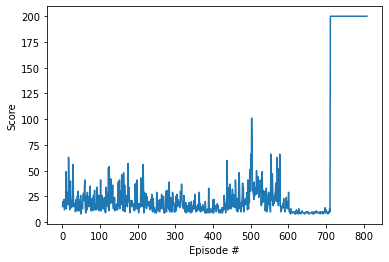

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
"""
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        
"""

### 5. Watch a Smart Agent!

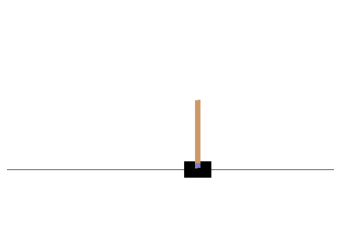

In [25]:
env = gym.make('CartPole-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(200):
    #breakpoint()
    action = policy.pick_action(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

In [6]:
policy.w

array([[562.98370792, 543.48113433],
       [527.02164227, 550.05989285],
       [549.49033216, 571.60136323],
       [556.09091848, 578.48430312]])

### 6. Get History

In [7]:
%%time
distribution = []
weights_history = []
for i in range(1000):
    env = gym.make('CartPole-v0')
    env.seed(i)
    np.random.seed(i)

    policy = Policy()
    scores = hill_climbing_AN(verbose=False)
    distribution.append(len(scores))
    weights_history.append(policy.w)

Wall time: 45min 16s


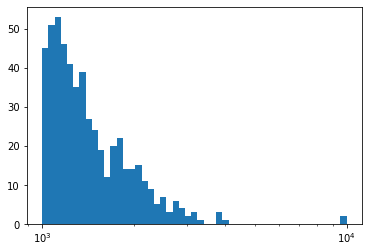

In [8]:
ep_needed = np.array(distribution)
bins=np.logspace(np.log10(1000),np.log10(10000), 50)

plt.figure()
plt.hist(ep_needed, bins)
plt.gca().set_xscale("log")
plt.show()

In [9]:
sum(ep_needed < 10000) / len(ep_needed)

0.998

##### Save history

In [10]:
# Save history of Episodes needed
pd.Series(distribution).to_csv('HC_AN_S.csv')

# Save weights
arr = np.array(weights_history)
indx = pd.MultiIndex.from_product([range(s)for s in arr.shape], names=['run', 'x', 'y'])
df = pd.Series(arr.flatten(), index=indx).unstack()
df.to_pickle('HC_AN_w_S.df')